In [2]:
!pip install seaborn
!pip install scikit-learn
!pip install pandas
!pip install tensorflow --user


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os
import glob
import pandas as pd
import numpy as np

# as above , but use a file list as argument
def create_windowed_dataset_files(file_list, window_size=900, slide_size=450):

    X = []  # Will hold the windows of sensor data
    y = []  # Will hold the activity labels for each window

    #create full_df to holld all data
    full_df = pd.DataFrame()

    for file_path in file_list:
        filename = os.path.basename(file_path)
        label = filename.split('.')[0]  # activity label is everything before '.'

        # Read CSV, skipping the first line
        temp_df = pd.read_csv(
            file_path,
            skiprows=1,   # skip the first line
            header=None,  # provide custom column names
            names=['timestamp', 'accX', 'accY', 'accZ', 'pressure', 'gyroX', 'gyroY', 'gyroZ']
        )

        # Convert columns to numeric
        temp_df['timestamp'] = pd.to_numeric(temp_df['timestamp'], errors='coerce')
        temp_df['accX'] = pd.to_numeric(temp_df['accX'], errors='coerce')
        temp_df['accY'] = pd.to_numeric(temp_df['accY'], errors='coerce')
        temp_df['accZ'] = pd.to_numeric(temp_df['accZ'], errors='coerce')
        temp_df['pressure'] = pd.to_numeric(temp_df['pressure'], errors='coerce')
        temp_df['gyroX'] = pd.to_numeric(temp_df['gyroX'], errors='coerce')
        temp_df['gyroY'] = pd.to_numeric(temp_df['gyroY'], errors='coerce')
        temp_df['gyroZ'] = pd.to_numeric(temp_df['gyroZ'], errors='coerce')
        #append label
        temp_df['activity'] = label

        # Drop any rows with NaNs if that makes sense for your data
        # temp_df.dropna(inplace=True)

        # Slide through the file using window_size and slide_size
        num_rows = len(temp_df)
        for start_idx in range(0, num_rows - window_size + 1, slide_size):
            end_idx = start_idx + window_size
            window_data = temp_df.iloc[start_idx:end_idx]

            # Exclude the activity column (doesn't exist here), so just select sensor columns
            # We'll include timestamp, accX, accY, accZ
            # Shape will be (window_size, 4) for each window
            window_array = window_data[['timestamp', 'accX', 'accY', 'accZ', 'pressure', 'gyroX', 'gyroY', 'gyroZ']].values

            # Append the window to X
            X.append(window_array)

            # Append the activity label to y
            # (we assume the entire window belongs to the same activity)
            y.append(label)

        #apped temp_df to full_df
        full_df = pd.concat([temp_df, full_df], ignore_index=True)


    # Convert X and y to numpy arrays
    X = np.array(X)  # shape -> (number_of_windows, window_size, 4)
    y = np.array(y)  # shape -> (number_of_windows,)
    return X, y, full_df



In [20]:
import os
import glob
import pandas as pd
import numpy as np

def get_class_from_filename(filename):
    # Extract class from filename, e.g., 'bagbord.hoj.003.csv' -> 'hoj'
    parts = filename.split('.')
    for part in parts:
        if part in ['hoj', 'ret', 'lav']:
            return part
    return None

def split_files_by_class_and_fraction(file_list, window_size=150, slide_size=75):
    X_train, y_train, X_test, y_test = [], [], [], []
    train_full_df = pd.DataFrame()
    test_full_df = pd.DataFrame()

    for file_path in file_list:
        filename = os.path.basename(file_path)
        class_label = get_class_from_filename(filename)
        if class_label is None:
            continue  # skip files not in hoj, ret, lav

        temp_df = pd.read_csv(
            file_path,
            skiprows=1,
            header=None,
            names=['timestamp', 'accX', 'accY', 'accZ', 'pressure', 'gyroX', 'gyroY', 'gyroZ']
        )
        temp_df['activity'] = class_label

        n = len(temp_df)
        split_idx = int(n * 2 / 3)
        train_df = temp_df.iloc[:split_idx]
        test_df = temp_df.iloc[split_idx:]

        # Windowing for train
        for start_idx in range(0, len(train_df) - window_size + 1, slide_size):
            end_idx = start_idx + window_size
            window_data = train_df.iloc[start_idx:end_idx]
            X_train.append(window_data[['timestamp', 'accX', 'accY', 'accZ', 'pressure', 'gyroX', 'gyroY', 'gyroZ']].values)
            y_train.append(class_label)

        # Windowing for test
        for start_idx in range(0, len(test_df) - window_size + 1, slide_size):
            end_idx = start_idx + window_size
            window_data = test_df.iloc[start_idx:end_idx]
            X_test.append(window_data[['timestamp', 'accX', 'accY', 'accZ', 'pressure', 'gyroX', 'gyroY', 'gyroZ']].values)
            y_test.append(class_label)

        train_full_df = pd.concat([train_full_df, train_df], ignore_index=True)
        test_full_df = pd.concat([test_full_df, test_df], ignore_index=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, train_full_df, X_test, y_test, test_full_df

# Usage:
data_dir = 'expanded_data'  # or your actual path
all_files = glob.glob(os.path.join(data_dir, '*.csv'))
X_train_data, y_train_data, train_df, X_test_data, y_test_data, test_df = split_files_by_class_and_fraction(
    all_files, window_size=150, slide_size=75
)

print("X_train shape:", X_train_data.shape)
print("y_train shape:", y_train_data.shape)
print("X_test shape:", X_test_data.shape)
print("y_test shape:", y_test_data.shape)

X_train shape: (1947, 150, 8)
y_train shape: (1947,)
X_test shape: (961, 150, 8)
y_test shape: (961,)


(array([308.,   0.,   0.,   0.,   0., 321.,   0.,   0.,   0., 332.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

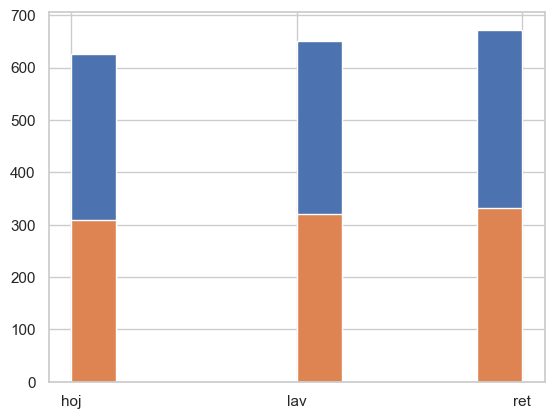

In [21]:
import matplotlib.pyplot as plt

plt.hist(y_train_data)
plt.hist(y_test_data)

In [22]:
from scipy.signal import find_peaks

def extract_features(X, y, window_size=150):
    records = []
    for i in range(X.shape[0]):
        x_list = X[i, :, 1]  # accX
        y_list = X[i, :, 2]  # accY
        z_list = X[i, :, 3]  # accZ
        pressure_list = X[i, :, 4]
        gyroY_list = X[i, :, 6]

        record = {
            # mean
            'y_mean': np.mean(y_list),
            'pressure_mean': np.mean(pressure_list),
            'gyroY_mean': np.mean(gyroY_list),
            # min
            'y_min': np.min(y_list),
            'pressure_min': np.min(pressure_list),
            # median
            'y_median': np.median(y_list),
            'pressure_median': np.median(pressure_list),
            # number of peaks
            'pressure_peak_count': len(find_peaks(pressure_list)[0]),
            # energy
            'y_energy': np.sum(y_list**2) / window_size,
            'pressure_energy': np.sum(pressure_list**2) / window_size,
            # signal magnitude area (SMA)
            'sma': (np.sum(np.abs(x_list)) + np.sum(np.abs(y_list)) + np.sum(np.abs(z_list))) / window_size,
            # custom ratio
            'acc_gyro_ratio_y': np.mean(y_list) / (np.mean(gyroY_list) + 1e-6),
            # activity label
            'activity': y[i]
        }
        records.append(record)
    feature_df = pd.DataFrame(records)
    return feature_df

In [23]:
# extract features from the training data
train_feature_df = extract_features(X_train_data, y_train_data)
print(train_feature_df.head())
print(train_feature_df.shape)

# extract features from the testing data
test_feature_df = extract_features(X_test_data, y_test_data)
print(test_feature_df.head())
print(test_feature_df.shape)


       y_mean  pressure_mean  gyroY_mean   y_min  pressure_min  y_median  \
0  213.460000    2048.406667   25.153333 -7812.0        2038.0       0.0   
1  -57.273333    2048.773333   21.660000 -1562.0        2036.0       0.0   
2 -203.060000    2049.020000   20.800000 -1562.0        2036.0       0.0   
3 -192.646667    2048.366667   20.873333 -1562.0        2037.0       0.0   
4 -145.786667    2047.993333   20.433333  -781.0        2038.0       0.0   

   pressure_median  pressure_peak_count       y_energy  pressure_energy  \
0           2048.0                   52  736227.900000     4.195998e+06   
1           2049.0                   51  313113.313333     4.197502e+06   
2           2049.0                   47  443238.326667     4.198514e+06   
3           2048.0                   46  394441.446667     4.195834e+06   
4           2048.0                   45  235851.586667     4.194300e+06   

             sma  acc_gyro_ratio_y activity  
0  102129.580000          8.486350      hoj  


In [24]:
# get test and train data from test_feature_df and train_feature_df
X_train = train_feature_df.drop('activity', axis=1)
y_train = train_feature_df['activity']

X_test = test_feature_df.drop('activity', axis=1)
y_test = test_feature_df['activity']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

# Suppose y_train_data is your array of string labels, e.g., ['walk', 'sit', ...]
# First, encode the strings to integers.
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)

# Convert integer labels to one-hot vectors.
y_train_onehot = keras.utils.to_categorical(y_train_int)

#also convert test data
y_test_int = le.transform(y_test)
y_test_onehot = keras.utils.to_categorical(y_test_int)

# Find the number of classes (should match the one-hot vector's length).
num_classes = y_train_onehot.shape[1]
print(f'Number of classes: {num_classes}')


X_train shape: (1947, 12)
y_train shape: (1947,)
X_test shape: (961, 12)
y_test shape: (961,)
Number of classes: 3


In [25]:
#plot X_train to see if we need std scaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

def plotFeatures(data):
    # Set the figure size
    plt.figure(figsize=(14, 12))
    # Plot the features
    for i in range(13):
        plt.subplot(7, 2, i + 1)
        sns.histplot(data.iloc[:, i], bins=30, kde=True)
        #sns.histplot(X_train.iloc[:, i], bins=30, kde=True)
        plt.title(f'Feature {data.columns[i]} Distribution')
        #plt.title(f'Feature {X_train.columns[i]} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

IndexError: single positional indexer is out-of-bounds

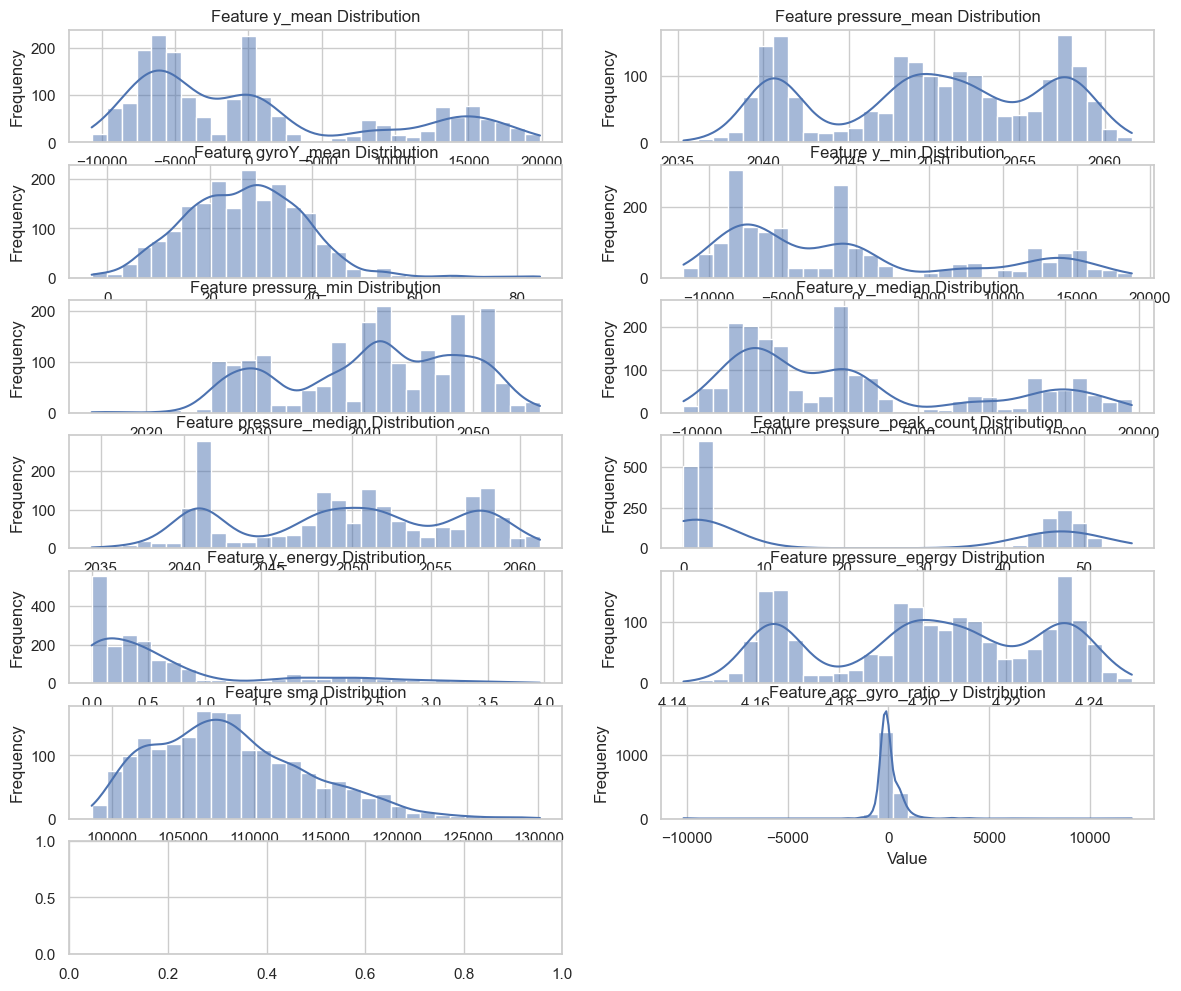

In [26]:
plotFeatures(X_train)

IndexError: single positional indexer is out-of-bounds

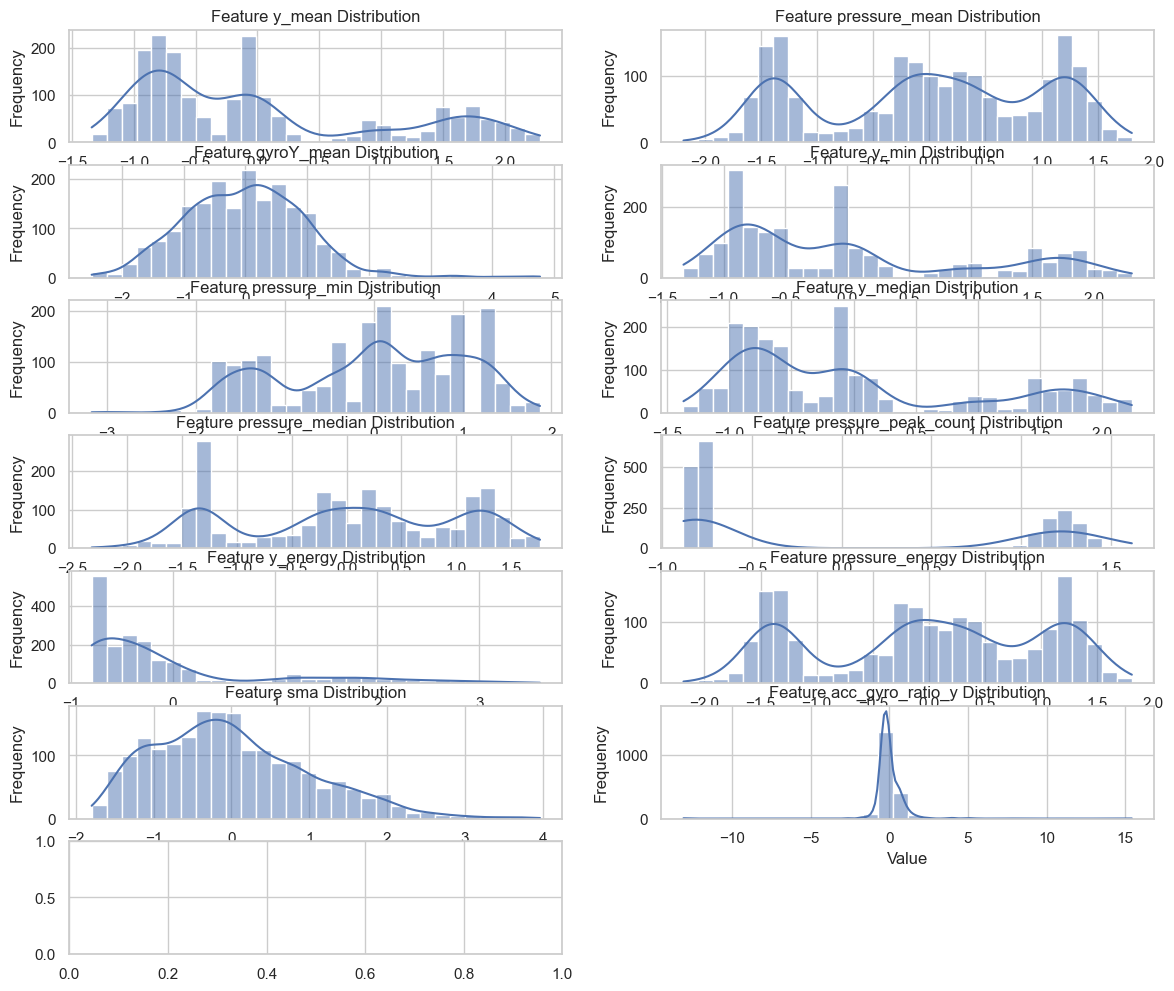

In [27]:
#import standard scaler
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the training data
scaler.fit(X_train)
# Transform the training data
X_train_scaled = scaler.transform(X_train)
# Transform the testing data
X_test_scaled = scaler.transform(X_test)
# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

plotFeatures(X_train_scaled)

In [28]:
# get offset and scale from scaler
#we need to perform : z = (x - u) / s
offset = scaler.mean_
scale = scaler.scale_
print("Offset:", offset)
print("Scale:", scale)

Offset: [ 6.24728834e+02  2.04972811e+03  2.69639780e+01 -5.97332752e+02
  2.04085217e+03  6.20180377e+02  2.04967015e+03  1.97544941e+01
  7.19706919e+07  4.20144897e+06  1.08398729e+05  3.49541864e+01]
Scale: [8.43188780e+03 6.57038512e+00 1.20626484e+01 8.39241997e+03
 8.15693988e+00 8.43542021e+03 6.54148515e+00 2.24093752e+01
 9.02352958e+07 2.69247704e+04 5.47821535e+03 7.81474459e+02]


In [29]:
#print mean_ and scale_ above as const C arrays

def print_array_as_c(var_name, array, floats_per_line=8):
    """
    Print a NumPy array as a static const float[] in C.
    """
    flat = array.flatten()
    print(f"static const float {var_name}[] = {{")
    line = []
    for i, val in enumerate(flat):
        line.append(f"{val:.8f}")
        if (i+1) % floats_per_line == 0 and (i+1) < len(flat):
            print("    " + ", ".join(line) + ",")
            line = []
    if line:
        print("    " + ", ".join(line) + ",")
    print("};\n")

# Print the offset and scale arrays
print_array_as_c("offset", offset)
print_array_as_c("scale", scale)
 

static const float offset[] = {
    624.72883434, 2049.72810710, 26.96397796, -597.33275153, 2040.85216705, 620.18037685, 2049.67014585, 19.75449409,
    71970691.87438874, 4201448.96774817, 108398.72872062, 34.95418637,
};

static const float scale[] = {
    8431.88779958, 6.57038512, 12.06264837, 8392.41996964, 8.15693988, 8435.42021335, 6.54148515, 22.40937520,
    90235295.75790536, 26924.77040946, 5478.21534949, 781.47445894,
};



In [30]:
y_test_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [31]:
X_train_scaled.shape[1]

12

In [42]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Split the training data into a training and validation set
#X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_onehot, test_size=0.2, random_state=42)
# Define the model
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(8, activation='relu', input_shape=13,),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')  # num_classes is the number of unique labels
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_split, y_train_split, epochs=150, batch_size=32, validation_data=(X_val_split, y_val_split), callbacks=[early_stopping])


Epoch 1/150


C:\Users\Jacob\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5218 - loss: 1.0600 - val_accuracy: 0.5667 - val_loss: 1.0349
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5376 - loss: 1.0418 - val_accuracy: 0.5897 - val_loss: 1.0183
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5600 - loss: 1.0261 - val_accuracy: 0.6385 - val_loss: 1.0008
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6524 - loss: 1.0037 - val_accuracy: 0.6641 - val_loss: 0.9822
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6857 - loss: 0.9873 - val_accuracy: 0.6821 - val_loss: 0.9627
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6814 - loss: 0.9669 - val_accuracy: 0.6949 - val_loss: 0.9424
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6907 - loss: 0.9501 - val_accuracy: 0.7051 - val_loss: 0.9205
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7064 - loss: 0.9225 - val_accuracy: 0.7179 - val_loss: 0.8

In [33]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [43]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115 (4.36 KB)

 Trainable params: 371 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 744 (2.91 KB)

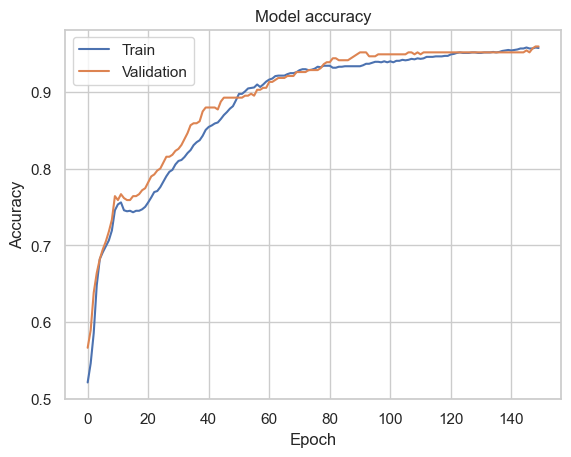

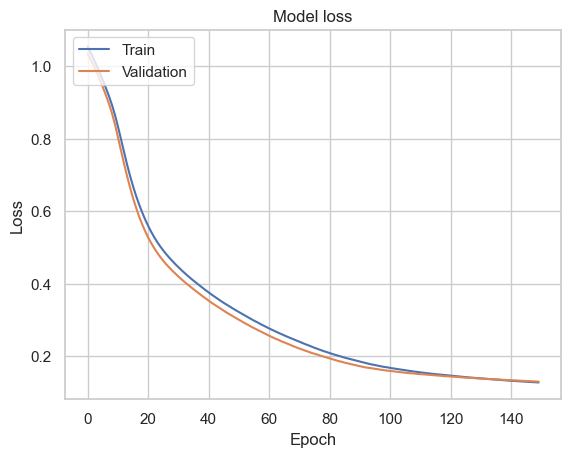

In [44]:
#plot history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9543 - loss: 0.1297 
Test loss: 0.27503371238708496
Test accuracy: 0.8959417343139648
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


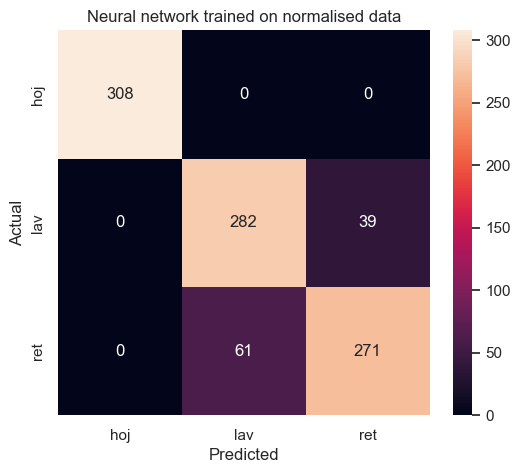

In [45]:
# validate using X_test and y_test_onehot
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

#plot a confusion_matrix using seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted classes
pred = model.predict(X_test_scaled)
# get highes values
y_pred = np.argmax(pred, axis=1)
y_true = y_test_int

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_test_data), yticklabels=np.unique(y_test_data))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural network trained on normalised data')
plt.show()



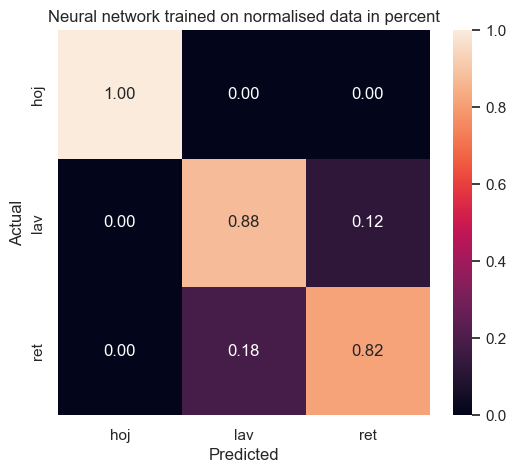

In [46]:
#abonve in percent
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(y_test_data), yticklabels=np.unique(y_test_data))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural network trained on normalised data in percent')
plt.show()

In [48]:
# store the model
model.save('model.keras')

In [49]:
# get the weights
weights = model.get_weights()


# get all weithgt and print

for i in range(len(weights)):
    print(f'Layer {i} has shape {weights[i].shape}')


Layer 0 has shape (12, 8)
Layer 1 has shape (8,)
Layer 2 has shape (8, 8)
Layer 3 has shape (8,)
Layer 4 has shape (8, 16)
Layer 5 has shape (16,)
Layer 6 has shape (16, 3)
Layer 7 has shape (3,)


In [51]:
import numpy as np
import textwrap

def print_array_as_c(var_name, array, floats_per_line=8):
    """
    Print a NumPy array as a static const float[] in C.
    """
    flat = array.flatten()
    print(f"static const float {var_name}[] = {{")
    line = []
    for i, val in enumerate(flat):
        line.append(f"{val:.8f}")
        if (i+1) % floats_per_line == 0 and (i+1) < len(flat):
            print("    " + ", ".join(line) + ",")
            line = []
    if line:
        print("    " + ", ".join(line) + ",")
    print("};\n")

def export_keras_to_c(model):
    """
    Export all layer weights from a Keras model to C arrays.
    Handles Conv1D (transposing to AIfES conv2d channels-first),
    and Dense layers. Ignores other layers (pooling, flatten, dropout, etc.).
    """
    layer_index = 0
    for layer in model.layers:
        w = layer.get_weights()
        if not w:
            # e.g. pooling or dropout has no weights
            layer_index += 1
            continue

        weights, biases = w
        layer_name = layer.__class__.__name__
    
        if layer_name == "Dense":
            # Keras shape: (in_neurons, out_neurons)
            # AIfES expects: (out_neurons, in_neurons) if we treat "weights" as (out,in).
            weights_t = np.transpose(weights, (1, 0))

            kernel_name = f"dense{layer_index}_kernel"
            bias_name   = f"dense{layer_index}_bias"

            print_array_as_c(kernel_name, weights_t)
            print_array_as_c(bias_name, biases)
        
        layer_index += 1

# Usage:
#model.save('../Data/model/dense_model_8_16.keras')
model = keras.models.load_model('model.keras')
export_keras_to_c(model)

static const float dense0_kernel[] = {
    0.53754139, -0.34045544, 0.39919481, 0.03383585, 0.36282009, -0.20484899, -0.17620443, -0.19969594,
    0.46340668, -0.56306034, 0.15739767, -0.04653430, -0.53889734, -0.69613248, -0.02329913, 0.33683193,
    -0.11651836, -0.20333920, 0.22585432, -0.67039454, 0.11725124, -0.42093331, -0.03978767, -0.11486426,
    0.42561898, -0.48926654, 0.24562827, 0.17415789, 0.15952069, 0.36889473, -0.52781808, -0.08884893,
    -0.86149842, 0.41926649, -0.55674183, 0.19133043, 0.15043212, -0.22659686, -0.17856799, -0.38116768,
    0.29643285, 0.45698956, -0.14799795, -0.00329376, -0.13524079, 0.49500221, -0.49244696, 0.14138332,
    0.43536928, 0.38893527, -0.04217335, -0.09279142, -0.40685377, 0.09506965, 0.33842590, 0.20869833,
    0.76501578, -0.01266095, -0.21534951, -0.24533312, -0.33033442, 0.33566374, -0.28177997, -0.72704154,
    0.10618488, -0.44308373, 0.35088357, 0.08724560, 0.44399962, 0.05724105, -0.32073483, 0.10335237,
    -0.31701943, 0.6309